## 1. Import & cấu hình I/O

In [1]:
# !pip install networkx pandas numpy matplotlib scipy tqdm

import os, math, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import spearmanr

# Thư mục I/O
DATA_DIR = Path("Threads_Dataset")     # chứa posts.csv, users.csv (xem Cell 2)
OUT_DIR  = Path("output")   # nơi lưu CSV/ảnh kết quả
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Đặt seed để reproducible
random.seed(42); np.random.seed(42)
plt.rcParams["figure.figsize"] = (8,5)


## 2. Đọc dữ liệu & chuẩn hóa cột

In [2]:
users = pd.read_csv(DATA_DIR/"users.csv")   # link_in_bio, biography, n_followers, user_name, user_url, name
posts = pd.read_csv(DATA_DIR/"posts.csv")   # media, n_likes, user_url, timestamp, post_url, caption_text, parent_url

# Chuẩn hóa kiểu dữ liệu tối thiểu
for col in ["user_url", "post_url", "parent_url"]:
    if col in posts.columns:
        posts[col] = posts[col].astype(str).str.strip()

users["user_url"]  = users["user_url"].astype(str).str.strip()
users["user_name"] = users.get("user_name", pd.Series(index=users.index, dtype=str)).astype(str)
users["name"]      = users.get("name", pd.Series(index=users.index, dtype=str)).astype(str)

# Giữ chỉ những post có tác giả là user nằm trong users.csv
valid_users = set(users["user_url"])
posts = posts[posts["user_url"].isin(valid_users)].copy()

# Map: post_url -> author_user_url (để suy ra tác giả của parent_url)
post_to_author = posts.dropna(subset=["post_url"]) \
                      .drop_duplicates(subset=["post_url"]) \
                      .set_index("post_url")["user_url"].to_dict()

print(f"users: {len(users):,} | posts: {len(posts):,} | unique posts: {len(post_to_author):,}")


users: 55,393 | posts: 129,028 | unique posts: 129,028


## 3. Dựng đồ thị T (DiGraph)

In [3]:
G = nx.DiGraph()

# Thêm nút = tất cả user_url trong users.csv để giữ nhãn & follower counts
G.add_nodes_from(valid_users)

# Xây cạnh: commenter (child_author) -> parent_author
edge_weights = {}
rows = posts.dropna(subset=["parent_url"]).copy()

for _, r in rows.iterrows():
    child_author  = r["user_url"]         # người viết post/comment hiện tại
    parent_link   = r["parent_url"]       # URL của post cha
    parent_author = post_to_author.get(parent_link)

    if not parent_author:    # parent_url không tìm thấy tác giả → bỏ
        continue
    if child_author == parent_author:     # self-loop → bỏ
        continue

    key = (child_author, parent_author)
    edge_weights[key] = edge_weights.get(key, 0) + 1

# Nạp vào graph
for (u, v), w in edge_weights.items():
    G.add_edge(u, v, weight=float(w))

print(f"Directed? {G.is_directed()} | |V|={G.number_of_nodes():,} | |E|={G.number_of_edges():,}")


Directed? True | |V|=55,393 | |E|=89,327


## 4. Các thuộc tính cơ bản của mạng T

### 4.1. Thành phần liên thông lớn nhất (yếu) 

In [4]:
# Lấy WCC lớn nhất (đồ thị có hướng) và bản undirected để tái dùng
if isinstance(G, nx.DiGraph):
    comps = list(nx.weakly_connected_components(G))
    lcc_nodes = max(comps, key=len) if comps else set()
    G_wcc = G.subgraph(lcc_nodes).copy()
else:
    comps = list(nx.connected_components(G))
    lcc_nodes = max(comps, key=len) if comps else set()
    G_wcc = G.subgraph(lcc_nodes).copy()

GU = G_wcc.to_undirected()

# Tiện in nhanh kích thước
print(f"Max weakly CC size: {len(G_wcc):,}, undirected nodes (same) = {GU.number_of_nodes():,}")


Max weakly CC size: 54,257, undirected nodes (same) = 54,257


### 4.2. Density

In [5]:
density = nx.density(G)
print("Density:", density)
pd.DataFrame([["Density", density]], columns=["metric","value"]).to_csv(OUT_DIR/"metric_density.csv", index=False)

Density: 2.9112588112192357e-05


### 4.3.Average clustering coefficient (trên GU)

In [6]:
try:
    avg_clust = nx.average_clustering(GU)
except Exception:
    avg_clust = float("nan")

print("Average clustering coefficient:", avg_clust)
pd.DataFrame([["Average clustering coefficient", avg_clust]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_avg_clustering.csv", index=False)


Average clustering coefficient: 0.00622120330015176


### 4.4. Average shortest path length (trên GU) với fallback xấp xỉ

In [7]:
import math, random
asp = float("nan")
try:
    asp = nx.average_shortest_path_length(GU)
except Exception:
    sample = min(len(GU), int(math.sqrt(len(GU))) + 1)
    seeds = random.sample(list(GU.nodes()), sample) if len(GU)>0 else []
    dists = []
    for s in seeds:
        lengths = nx.single_source_shortest_path_length(GU, s)
        if lengths:
            dists.append(np.mean(list(lengths.values())))
    if dists:
        asp = float(np.mean(dists))

print("Average shortest path (approx):", asp)
pd.DataFrame([["Average shortest path (approx)", asp]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_avg_shortest_path.csv", index=False)


Average shortest path (approx): 5.0214339738927345


## 4.5. Diameter (trên GU) với fallback xấp xỉ

In [8]:
diam = float("nan")
try:
    diam = nx.diameter(GU)
except Exception:
    sample = min(len(GU), int(math.sqrt(len(GU))) + 1)
    seeds = random.sample(list(GU.nodes()), sample) if len(GU)>0 else []
    eccs = []
    for s in seeds:
        lengths = nx.single_source_shortest_path_length(GU, s)
        if lengths:
            eccs.append(max(lengths.values()))
    if eccs:
        diam = int(np.max(eccs))

print("Diameter (approx):", diam)
pd.DataFrame([["Diameter (approx)", diam]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_diameter.csv", index=False)


Diameter (approx): 14


## 4.6. Average indegree / outdegree

In [ ]:
indeg_avg  = np.mean([d for _, d in G.in_degree()])  if G.number_of_nodes() else float("nan")
outdeg_avg = np.mean([d for _, d in G.out_degree()]) if G.number_of_nodes() else float("nan")

print("Average indegree:", indeg_avg)
print("Average outdegree:", outdeg_avg)

pd.DataFrame([
    ["Average indegree", indeg_avg],
    ["Average outdegree", outdeg_avg],
], columns=["metric","value"]).to_csv(OUT_DIR/"metric_avg_degrees.csv", index=False)


Average indegree: 1.612604480710559
Average outdegree: 1.612604480710559


## 4.7. Assortativity (indegree & outdegree)

In [ ]:
try:
    indeg_assort = nx.degree_assortativity_coefficient(G, x="in", y="in")
except Exception:
    indeg_assort = float("nan")

try:
    outdeg_assort = nx.degree_assortativity_coefficient(G, x="out", y="out")
except Exception:
    outdeg_assort = float("nan")

print("Indegree assortativity:", indeg_assort)
print("Outdegree assortativity:", outdeg_assort)

pd.DataFrame([
    ["Indegree assortativity", indeg_assort],
    ["Outdegree assortativity", outdeg_assort],
], columns=["metric","value"]).to_csv(OUT_DIR/"metric_assortativity.csv", index=False)


Indegree assortativity: -0.024030081059292777
Outdegree assortativity: 0.09440445232593103


> Các đỉnh “nổi tiếng” (được nhiều đỉnh khác trỏ tới) hơi có xu hướng được liên kết bởi các đỉnh “ít nổi tiếng” hơn.
> Không thấy hiện tượng “người nổi tiếng follow người nổi tiếng” mạnh.
-> Mạng gần như trung tính
> 
> Các đỉnh có nhiều outgoing edges (out-degree cao) hơi có xu hướng trỏ tới các đỉnh cũng có nhiều outgoing edges.
> Người “tích cực kết nối/phát tán” thường nói chuyện, liên kết, hoặc follow với những người cũng “tích cực” tương tự.
-> M0ạng có xu hướng assortative nhẹ theo “mức độ hoạt động phát ra”.

## 4.8. Kích thước WCC lớn nhất (để đối chiếu bảng)

In [ ]:
max_wcc_size = len(G_wcc)
print("Maximum connected component’s size (weak):", max_wcc_size)
pd.DataFrame([["Maximum connected component’s size (weak)", max_wcc_size]],
             columns=["metric","value"]).to_csv(OUT_DIR/"metric_max_wcc_size.csv", index=False)


Maximum connected component’s size (weak): 54257


## Phân phối centralities

In [ ]:
# Tính centrality trên LCC undirected cho closeness/betweenness/eigenvector (ổn định & theo thông lệ SNA)
WCC_nodes = max(nx.weakly_connected_components(G), key=len)
G_wcc = G.subgraph(WCC_nodes).copy()
GU = G_wcc.to_undirected()

indeg = dict(G.in_degree())  # dùng cho "degree (in)"
# closeness: dùng GU để tránh vô cực
closeness = nx.closeness_centrality(GU)
# betweenness (có thể nặng) — dùng k-sampling nếu quá lớn
if GU.number_of_nodes() > 20000:
    k = int(2*math.sqrt(GU.number_of_nodes()))
    betweenness = nx.betweenness_centrality(GU, k=k, seed=42)
else:
    betweenness = nx.betweenness_centrality(GU)
# eigenvector
eigenvec = nx.eigenvector_centrality_numpy(GU)

def plot_semi_log(vals, title, fname):
    arr = np.array(list(vals.values()), dtype=float)
    arr = arr[~np.isnan(arr)]
    arr = arr[arr>0] if arr.min()>=0 else arr
    plt.figure()
    # histogram log-scale trên y
    plt.hist(arr, bins=100)
    plt.yscale("log")
    plt.title(title); plt.xlabel("value"); plt.ylabel("count (log)")
    plt.tight_layout()
    plt.savefig(OUT_DIR/fname, dpi=180)
    plt.show()

plot_semi_log(indeg,      "Indegree distribution (semi-log)",     "fig_indegree_semilog.png")
plot_semi_log(closeness,  "Closeness distribution (semi-log)",    "fig_closeness_semilog.png")
plot_semi_log(betweenness,"Betweenness distribution (semi-log)",  "fig_betweenness_semilog.png")
plot_semi_log(eigenvec,   "Eigenvector distribution (semi-log)",  "fig_eigenvector_semilog.png")

# Lưu bảng centralities
cent_df = pd.DataFrame({
    "user_id": list(GU.nodes()),
    "indegree": [indeg.get(u, 0) for u in GU.nodes()],
    "closeness": [closeness[u] for u in GU.nodes()],
    "betweenness": [betweenness[u] for u in GU.nodes()],
    "eigenvector": [eigenvec[u] for u in GU.nodes()],
})
cent_df.to_csv(OUT_DIR/"centralities.csv", index=False)
cent_df.head()


## Tương quan Spearman giữa 4 centralities

In [ ]:
cols = ["indegree","closeness","betweenness","eigenvector"]
corr = np.zeros((4,4))
for i, a in enumerate(cols):
    for j, b in enumerate(cols):
        r, _ = spearmanr(cent_df[a], cent_df[b])
        corr[i,j] = r

corr_df = pd.DataFrame(corr, index=cols, columns=cols)
corr_df.to_csv(OUT_DIR/"spearman_centralities.csv")
corr_df


,indegree,closeness,betweenness,eigenvector
indegree,1.000000,0.056599,0.340412,0.024026
closeness,0.056599,1.000000,0.505062,0.927252
betweenness,0.340412,0.505062,1.000000,0.419935
eigenvector,0.024026,0.927252,0.419935,1.000000


## Top-K% & giao nhau (định nghĩa Power Users của bài)
>Power users = các nút đồng thời thuộc top-K% của degree, closeness, betweenness, eigenvector. Trong bài chọn K=20 (theo lập luận phân phối lũy thừa & Pareto).

In [6]:
K = 20  # %
cent_df = pd.read_csv(OUT_DIR/"centralities.csv") 
n = len(cent_df)

def topK_idx(series, K):
    k = max(1, int(math.ceil(len(series) * (K/100.0))))
    return set(series.sort_values(ascending=False).head(k).index)

idxD = topK_idx(cent_df["indegree"],   K)
idxC = topK_idx(cent_df["closeness"],  K)
idxB = topK_idx(cent_df["betweenness"],K)
idxE = topK_idx(cent_df["eigenvector"],K)

# % giao nhau từng cặp (như Table 2)
def pct_inter(a,b):
    return 100.0 * len(a & b) / len(a | b) if (a|b) else 0.0

pair_stats = pd.DataFrame({
    "pair":["D∩C","D∩B","D∩E","C∩B","C∩E","B∩E"],
    "pct_common":[
        100*len(idxD & idxC)/n,
        100*len(idxD & idxB)/n,
        100*len(idxD & idxE)/n,
        100*len(idxC & idxB)/n,
        100*len(idxC & idxE)/n,
        100*len(idxB & idxE)/n,
    ]
})
pair_stats.to_csv(OUT_DIR/"table2_like_pairs.csv", index=False)

# Power users = giao của cả 4 tập
power_idx = idxD & idxC & idxB & idxE
power_users = cent_df.loc[list(power_idx), :].copy()
pct_power = 100.0 * len(power_users)/n

print(f"Power users: {len(power_users):,} / {n:,} ({pct_power:.2f}%)")
power_users.to_csv(OUT_DIR/"power_users.csv", index=False)
power_users.head()


Power users: 1,127 / 54,257 (2.08%)


,user_id,indegree,closeness,betweenness,eigenvector
51200,16f4835b9e019bbc5977fb5695206a4,124,0.242281,0.004236,0.001344
8199,1959d26e2adc749940738170abdfd12,0,0.242989,0.000305,0.004573
26631,8f4ac621791823370a019886a382eda,92,0.237709,0.000705,0.009874
4108,ca3e3fe936c31ddc6b1e9abbe9c1c49,0,0.237584,0.000017,0.010282
6156,ac52e9dd0a4152da604868121529f68,0,0.236502,0.000286,0.002061


### để định nghĩa power_user

## So sánh thuộc tính T vs P

In [ ]:
# === Utilities: basic graph stats (works for DiGraph/Graph) ===
import numpy as np, networkx as nx

def basic_stats(G: nx.Graph):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)

    # Choose largest weakly/strongly connected component for path metrics
    if G.is_directed():
        comps = list(nx.weakly_connected_components(G))
    else:
        comps = list(nx.connected_components(G))
    lcc_nodes = max(comps, key=len) if comps else set()
    G_wcc = G.subgraph(lcc_nodes).copy()

    # Undirected view for clustering/path metrics
    GU = G_wcc.to_undirected()

    # Average clustering
    try:
        avg_clust = nx.average_clustering(GU) if GU.number_of_nodes() > 0 else float("nan")
    except Exception:
        avg_clust = float("nan")

    # Average indegree (only meaningful for DiGraph)
    if G.is_directed():
        try:
            avg_indeg = float(np.mean([d for _, d in G.in_degree()])) if n > 0 else float("nan")
        except Exception:
            avg_indeg = float("nan")
    else:
        avg_indeg = float("nan")

    # APL & Diameter with safe fallbacks
    def apl_and_diam(H: nx.Graph):
        if H.number_of_nodes() <= 1:
            return float("nan"), float("nan")
        try:
            apl = nx.average_shortest_path_length(H)
        except Exception:
            apl = float("nan")
        try:
            diam = nx.diameter(H)
        except Exception:
            # 2-sweep heuristic lower bound
            try:
                s = next(iter(H))
                dist1 = nx.single_source_shortest_path_length(H, s)
                far1 = max(dist1, key=dist1.get)
                dist2 = nx.single_source_shortest_path_length(H, far1)
                diam = float(max(dist2.values()))
            except Exception:
                diam = float("nan")
        return apl, diam

    apl, diam = apl_and_diam(GU)

    return {
        "Number of nodes": n,
        "Number of arcs": m,
        "Density": density,
        "Average clustering coefficient": avg_clust,
        "Diameter (approx)": diam,
        "Average shortest path (approx)": apl,
        "Average indegree": avg_indeg,
    }


In [ ]:
# Subgraph P: chỉ các power users & cung giữa họ
P_nodes = set(power_users["user_id"])
P = G.subgraph(P_nodes).copy()

def normalized_avg_indegree(G: nx.DiGraph):
    n = G.number_of_nodes()
    if n == 0: return float("nan")
    avg_in = np.mean([d for _, d in G.in_degree()])
    return avg_in / n  # normalized by |V|

stats_P = basic_stats(P)
norm_avg_in_T = np.mean([d for _, d in G.in_degree()]) / max(1, G.number_of_nodes())
norm_avg_in_P = np.mean([d for _, d in P.in_degree()]) / max(1, P.number_of_nodes())

table4_like = pd.DataFrame({
    "Parameter":[
        "Number of nodes","Number of arcs","Density","Average clustering coefficient",
        "Diameter (approx)","Average shortest path (approx)","Average indegree","Normalized average indegree"
    ],
    # "Value in T":[
    #     stats_T["Number of nodes"], stats_T["Number of arcs"], stats_T["Density"],
    #     stats_T["Average clustering coefficient"], stats_T["Diameter (approx)"],
    #     stats_T["Average shortest path (approx)"], stats_T["Average indegree"], norm_avg_in_T
    # ],
    "Value in P":[
        stats_P["Number of nodes"], stats_P["Number of arcs"], stats_P["Density"],
        stats_P["Average clustering coefficient"], stats_P["Diameter (approx)"],
        stats_P["Average shortest path (approx)"], stats_P["Average indegree"], norm_avg_in_P
    ],
})
table4_like.to_csv(OUT_DIR/"table4_like_T_vs_P.csv", index=False)
table4_like


,Parameter,Value in P
0,Number of nodes,1127.000000
1,Number of arcs,3559.000000
2,Density,0.002805
3,Average clustering coefficient,0.025342
4,Diameter (approx),7.000000
5,Average shortest path (approx),3.580984
6,Average indegree,3.157941
7,Normalized average indegree,0.002802


## Nhận xét

**Number of nodes = 1 127, Number of arcs = 3 559**

- Nghĩa là có 1 127 power users và 3 559 cung giữa họ (nghĩa là chỉ xét tương tác power ↔ power).
- Trung bình mỗi người có khoảng 3.16 in-degree (xem dòng 6), tức là họ nhận được ~3 liên kết từ các power khác.
- Với mạng có hơn 1 000 đỉnh mà chỉ ~3 500 cung, ta thấy đây là đồ thị thưa (sparse), phần lớn power users không tương tác trực tiếp với nhau.

**Density = 0.002805**
Chỉ 0.28% trong tất cả các cặp người–người có thể có liên kết thực sự.
> ->Rất thưa — chỉ một phần rất nhỏ power users có mối quan hệ trực tiếp.
> 
> Điều này phù hợp với các mạng xã hội lớn: “elite users” không kết nối lẫn nhau nhiều mà thường tương tác với cộng đồng rộng hơn.

**Average clustering coefficient = 0.0253**

- Giá trị thấp (~0.025) → ít tam giác giữa các power users.
- Các power users không tạo thành cộng đồng khép kín, mà rải rác và kết nối lỏng lẻo.

**Diameter (approx) = 7, Average shortest path ≈ 3.58**

- Đường kính 7 nghĩa là xa nhất giữa hai power user bất kỳ là khoảng 7 bước.
- Đường đi ngắn trung bình chỉ ~3.6 bước → khá nhỏ: từ một power user tới một power khác chỉ cần vài bước trung gian.
> ->Điều này chỉ ra mạng vẫn liên thông hợp lý, dù rất thưa — có thể do một vài power users đóng vai “hub” trung gian.

**Average indegree = 3.16, Normalized average indegree = 0.002802**

- Mỗi power user nhận trung bình 3.16 cung từ power khác, phản ánh mức độ tập trung kết nối nhỏ.
- Điều này cũng phù hợp với mật độ: chỉ một phần rất nhỏ các power users thực sự được nhiều người khác trỏ tới.
> ->Có thể tồn tại một số ít power users mang "ảnh hưởng lớn", còn đa số chỉ kết nối ít.

## Tóm tắt nhận xét tổng thể
<table>
  <thead>
    <tr>
      <th>Khía cạnh</th>
      <th>Nhận xét</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Quy mô</td>
      <td>1 127 đỉnh, 3 559 cung → mạng power nhỏ hơn toàn mạng, khá thưa</td>
    </tr>
    <tr>
      <td>Mật độ &amp; clustering</td>
      <td>Rất thấp → power users không tạo nhóm chặt, ít tam giác</td>
    </tr>
    <tr>
      <td>Đường đi</td>
      <td>Ngắn (~3.6) → vẫn có tính “small-world”, có vài hub nối giữa power users</td>
    </tr>
    <tr>
      <td>In-degree trung bình</td>
      <td>~3.16 → mức tương tác inbound giữa power users thấp</td>
    </tr>
    <tr>
      <td>Tổng thể</td>
      <td>Power users có mạng con rời rạc, lỏng lẻo; nhưng vẫn liên thông qua một số hub trung gian, cho thấy tính trung gian cao của vài cá nhân nổi bật.</td>
    </tr>
  </tbody>
</table>


## So sánh phân phối indegree: tất cả vs power users

In [ ]:
table3_like = pd.DataFrame({
    "Group":["All users","Power users"],
    "Mean indegree":[cent_df["indegree"].mean(), power_users["indegree"].mean()],
    "Median indegree":[cent_df["indegree"].median(), power_users["indegree"].median()],
})
table3_like.to_csv(OUT_DIR/"table3_like_indegree.csv", index=False)
table3_like


NameError: name 'pd' is not defined

1. Downstream link prediction (2 model, khác định nghĩa power user)

2. Overlap & behaviour analysis

3. Additional predictive validity

4. Robustness & interpretability

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import random

# --- 0.1 Đọc power user SNA ---
power_sna = pd.read_csv(OUT_DIR / "power_users.csv")   
# cột chính là "user_id"
power_sna = power_sna[["user_id"]].copy()
power_sna["is_power_sna"] = 1

# --- 0.2 Đọc power user Opsahl ---
opsahl = pd.read_csv("opsahl_power_alpha05_Q3.csv")

# Đảm bảo có cột "user_id"
if "user_id" not in opsahl.columns:
    if "node" in opsahl.columns:
        opsahl = opsahl.rename(columns={"node": "user_id"})
    elif "user" in opsahl.columns:
        opsahl = opsahl.rename(columns={"user": "user_id"})

power_opsahl = opsahl[["user_id"]].copy()
power_opsahl["is_power_opsahl"] = 1

# --- 0.3 Tạo edge list từ G (child -> parent) ---
edges_df = pd.DataFrame(
    [(u, v, data.get("weight", 1.0)) for u, v, data in G.edges(data=True)],
    columns=["src", "dst", "weight"]
)
print("Số cạnh trong edges_df:", len(edges_df))


Số cạnh trong edges_df: 89327


## 1.1. Train/test split trên cạnh

In [5]:
# Chia random 80% cạnh để train, 20% để làm future edges
rng = np.random.RandomState(42)
mask = rng.rand(len(edges_df)) < 0.8

edges_train = edges_df[mask].copy()
edges_test  = edges_df[~mask].copy()

print("Train edges:", len(edges_train), " | Test edges:", len(edges_test))

# Build graph train
G_train = nx.DiGraph()
for _, r in edges_train.iterrows():
    G_train.add_edge(r["src"], r["dst"], weight=r["weight"])

GU_train = G_train.to_undirected()


Train edges: 71490  | Test edges: 17837


## 1.2. Tạo positive / negative pairs

In [ ]:
# Positive: cạnh trong test (xem như "link xuất hiện sau này")
pos_edges = edges_test[["src", "dst"]].drop_duplicates().copy()
pos_edges["label"] = 1

# Negative: sample non-edges
nodes = list(G_train.nodes())
neg_samples = set()

while len(neg_samples) < len(pos_edges):
    u = random.choice(nodes)
    v = random.choice(nodes)
    if u == v:
        continue
    if G_train.has_edge(u, v):
        continue
    neg_samples.add((u, v))

neg_edges = pd.DataFrame(list(neg_samples), columns=["src", "dst"])
neg_edges["label"] = 0

pairs = pd.concat([pos_edges, neg_edges], ignore_index=True)
print("Pairs:", pairs["label"].value_counts())


Pairs: label
1    17837
0    17837
Name: count, dtype: int64


## 1.3. Tính feature cấu trúc đơn giản

In [8]:
deg = dict(GU_train.degree())

def get_cn(u, v):
    if u not in GU_train or v not in GU_train:
        return 0
    return len(list(nx.common_neighbors(GU_train, u, v)))

def get_jaccard(u, v):
    if u not in GU_train or v not in GU_train:
        return 0.0
    try:
        return len(set(nx.common_neighbors(GU_train, u, v))) / \
               len(set(GU_train.neighbors(u)) | set(GU_train.neighbors(v)))
    except ZeroDivisionError:
        return 0.0

def get_pa(u, v):
    return deg.get(u, 0) * deg.get(v, 0)

rows_feat = []
for _, r in pairs.iterrows():
    u, v = r["src"], r["dst"]
    cn  = get_cn(u, v)
    jac = get_jaccard(u, v)
    pa  = get_pa(u, v)
    rows_feat.append((u, v, cn, jac, pa))

feat_basic = pd.DataFrame(rows_feat, columns=["src", "dst", "cn", "jaccard", "pa"])
features = pairs.merge(feat_basic, on=["src", "dst"], how="left").fillna(0.0)


## 1.4. Thêm feature power user cho 2 mô hình

In [9]:
# Model dùng Opsahl

feat_opsahl = features.merge(
    power_opsahl, left_on="src", right_on="user_id", how="left"
).rename(columns={"is_power_opsahl": "src_power_ops"}).drop(columns=["user_id"])

feat_opsahl = feat_opsahl.merge(
    power_opsahl, left_on="dst", right_on="user_id", how="left"
).rename(columns={"is_power_opsahl": "dst_power_ops"}).drop(columns=["user_id"])

feat_opsahl["src_power_ops"] = feat_opsahl["src_power_ops"].fillna(0).astype(int)
feat_opsahl["dst_power_ops"] = feat_opsahl["dst_power_ops"].fillna(0).astype(int)


In [10]:
# Model dùng SNA  
feat_sna = features.merge(
    power_sna, left_on="src", right_on="user_id", how="left"
).rename(columns={"is_power_sna": "src_power_sna"}).drop(columns=["user_id"])

feat_sna = feat_sna.merge(
    power_sna, left_on="dst", right_on="user_id", how="left"
).rename(columns={"is_power_sna": "dst_power_sna"}).drop(columns=["user_id"])

feat_sna["src_power_sna"] = feat_sna["src_power_sna"].fillna(0).astype(int)
feat_sna["dst_power_sna"] = feat_sna["dst_power_sna"].fillna(0).astype(int)


## 1.5. Train & so sánh AUC, AP, Precision@k

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

def train_eval(df, feature_cols, model_name="model"):
    X = df[feature_cols]
    y = df["label"]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)
    y_proba = clf.predict_proba(X_te)[:, 1]

    auc = roc_auc_score(y_te, y_proba)
    ap  = average_precision_score(y_te, y_proba)

    # Precision@k
    k = min(1000, len(y_te))
    idx_topk = np.argsort(-y_proba)[:k]
    prec_at_k = y_te.iloc[idx_topk].mean()

    print(f"{model_name}: AUC={auc:.4f}, AP={ap:.4f}, P@{k}={prec_at_k:.4f}")
    return auc, ap, prec_at_k

base_cols = ["cn", "jaccard", "pa"]

auc_O, ap_O, pO = train_eval(
    feat_opsahl, base_cols + ["src_power_ops", "dst_power_ops"],
    model_name="Opsahl model"
)
auc_S, ap_S, pS = train_eval(
    feat_sna, base_cols + ["src_power_sna", "dst_power_sna"],
    model_name="SNA model"
)


Opsahl model: AUC=0.9905, AP=0.9869, P@1000=0.9900
SNA model: AUC=0.9906, AP=0.9887, P@1000=0.9920


# 2️⃣ Overlap & Behaviour Analysis

## 2.1. Jaccard + nhóm A/B/C

In [12]:
set_ops = set(power_opsahl["user_id"])
set_sna = set(power_sna["user_id"])

inter = set_ops & set_sna
union = set_ops | set_sna
jaccard = len(inter) / len(union)

print("Jaccard giữa 2 tập power user:", jaccard)
print("Opsahl only  :", len(set_ops - set_sna))
print("SNA only     :", len(set_sna - set_ops))
print("Cả hai (both):", len(inter))

only_ops = set_ops - set_sna   # Nhóm A
only_sna = set_sna - set_ops   # Nhóm B
both     = inter               # Nhóm C


Jaccard giữa 2 tập power user: 0.25493060628195763
Opsahl only  : 242
SNA only     : 778
Cả hai (both): 349


## 2.2. So sánh độ trung tâm của 3 nhóm A/B/C

In [13]:
cent_df = pd.read_csv(OUT_DIR / "centralities.csv")

pd.set_option("display.max_columns", None)   # không ẩn cột
pd.set_option("display.width", 200)         # tăng độ rộng dòng
pd.set_option("display.max_rows", None)     # không ẩn dòng

def label_group(u):
    if u in both:
        return "C_both"
    elif u in only_ops:
        return "A_only_opsahl"
    elif u in only_sna:
        return "B_only_sna"
    else:
        return "None"

cent_df["group"] = cent_df["user_id"].map(label_group)

stats = cent_df.groupby("group")[["indegree", "closeness", "betweenness", "eigenvector"]].describe()
print(stats)


              indegree                                                           closeness                                                                       betweenness                      \
                 count        mean         std   min   25%   50%     75%     max     count      mean       std       min       25%       50%       75%       max       count      mean       std   
group                                                                                                                                                                                              
A_only_opsahl    242.0   64.388430   34.601075  28.0  42.0  53.0   74.75   279.0     242.0  0.220852  0.012359  0.182594  0.213013  0.221111  0.228685  0.257530       242.0  0.001844  0.001658   
B_only_sna       778.0    2.105398    7.040731   0.0   0.0   0.0    0.00    37.0     778.0  0.237439  0.007497  0.223823  0.231925  0.237112  0.242702  0.266743       778.0  0.000224  0.000433   
C_both           349

# 3️⃣ Additional Predictive Validity (outcome khác)

In [17]:
# users.csv đã có n_followers
followers = users[["user_url", "n_followers"]].copy()
followers = followers.rename(columns={"user_url": "user"})

# Map user -> group A/B/C/None
followers["group"] = followers["user"].map(label_group)

# Đánh dấu top 10% followers
thres = followers["n_followers"].quantile(0.9)
followers["is_top10_followers"] = (followers["n_followers"] >= thres).astype(int)

# Xem trong từng group, tỉ lệ thuộc top 10% là bao nhiêu
outcome_stats = followers.groupby("group")["is_top10_followers"].mean()
print(outcome_stats)


group
A_only_opsahl    0.342975
B_only_sna       0.167095
C_both           0.234957
None             0.097124
Name: is_top10_followers, dtype: float64


# 4️⃣ Robustness & Interpretability

## 4.1. Noise test (xóa ngẫu nhiên 10% cạnh, tính lại SNA power users)

In [18]:
def drop_edges_random(G, drop_ratio=0.1, seed=42):
    rng = np.random.RandomState(seed)
    edges = list(G.edges())
    keep_mask = rng.rand(len(edges)) > drop_ratio
    G_new = nx.DiGraph()
    G_new.add_nodes_from(G.nodes())
    for keep, (u, v) in zip(keep_mask, edges):
        if keep:
            w = G[u][v].get("weight", 1.0)
            G_new.add_edge(u, v, weight=w)
    return G_new

G_noisy = drop_edges_random(G, drop_ratio=0.1)

# → Từ G_noisy, bạn có thể chạy lại đoạn:
# - tìm WCC
# - GU_noisy = G_noisy.to_undirected()
# - tính indegree, closeness, betweenness, eigenvector
# - chọn power_idx_noisy = giao 4 top-K
# - so sánh Jaccard(power_sna_old, power_sna_noisy)


## 4.2. Ego-network case study

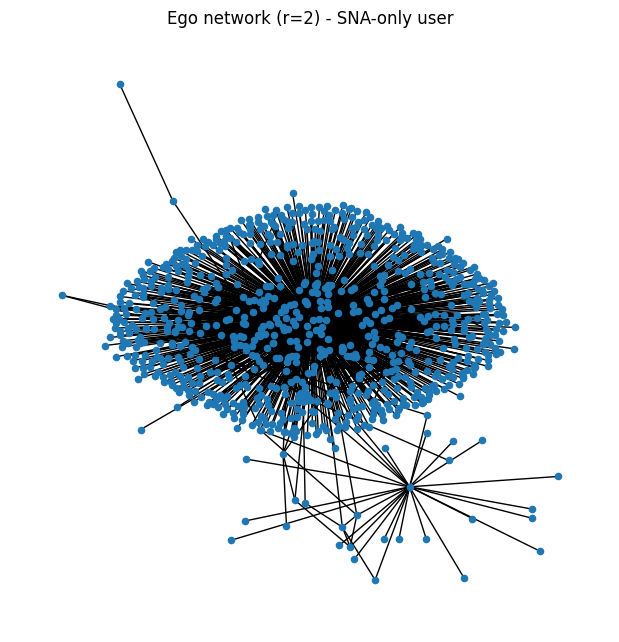

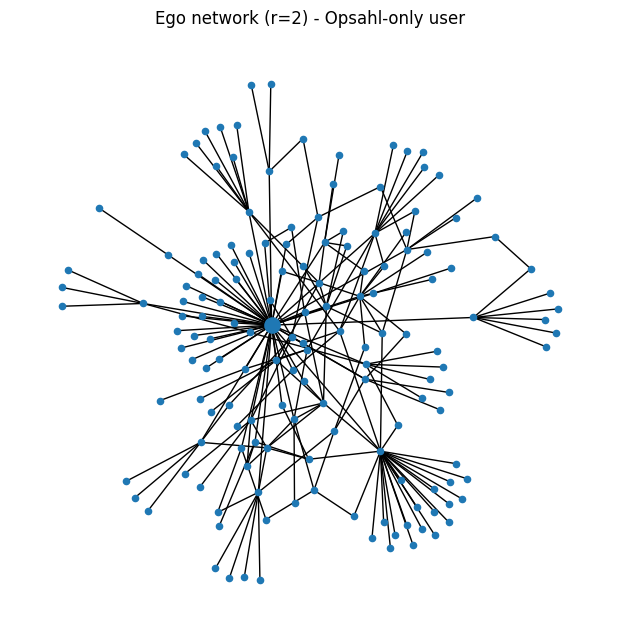

In [19]:
import matplotlib.pyplot as plt

GU_full = G.to_undirected()

# chọn 1 user SNA-only
u_sna = next(iter(only_sna))
ego_sna = nx.ego_graph(GU_full, u_sna, radius=2)

plt.figure(figsize=(6,6))
pos = nx.spring_layout(ego_sna, seed=42)
nx.draw(ego_sna, pos, node_size=20, with_labels=False)
nx.draw_networkx_nodes(ego_sna, pos, nodelist=[u_sna], node_size=120)
plt.title(f"Ego network (r=2) - SNA-only user")
plt.show()

# tương tự cho 1 user Opsahl-only
u_ops = next(iter(only_ops))
ego_ops = nx.ego_graph(GU_full, u_ops, radius=2)

plt.figure(figsize=(6,6))
pos = nx.spring_layout(ego_ops, seed=42)
nx.draw(ego_ops, pos, node_size=20, with_labels=False)
nx.draw_networkx_nodes(ego_ops, pos, nodelist=[u_ops], node_size=120)
plt.title(f"Ego network (r=2) - Opsahl-only user")
plt.show()
